In [2]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict,Annotated ,Literal
import google.generativeai as genai
from pydantic import BaseModel,Field
import operator 
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os

load_dotenv()

## load model 
os.environ["GOOGLE_API_KEY"] = os.getenv("gen_api")

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

In [3]:
## for structured output of diagnoses
class schema(BaseModel):
    issue_type : Literal["ux","billing problem","defected",'others']=Field(description="provide issue type ogf text")
    urgency : Literal['low level',"mid level","high level"]=Field(description="provide a uergecy type of a text")
    tone : Literal["angry","frustated","sad","happy"]=Field(description="provide a tone of text")

In [4]:
## for structure output for sentiment analysis
class structure(BaseModel):

    sentiment : Literal["positive","negative"]= Field(description = "give a sentiment of a text")

In [5]:
## structured gemini model 
structured_model = model.with_structured_output(structure)
structured_model2 = model.with_structured_output(schema)

In [6]:
# define state 
class sentiment_state(TypedDict):
    text : str 
    sentiment : Literal["positive","negative"]
    diagnoses : dict
    response : str
    

In [7]:
## define fuction of nodes 
def sentiment(state : sentiment_state):
    prompt = f'evaluate the sentiment of a text or ticket text {state["text"]}sentiment positive negative '
    
    output = structured_model.invoke(prompt)
    return {"sentiment": output.sentiment}

def conditional(state : sentiment_state) -> Literal["positive_response","diagnoses_response"]:
    
    if state["sentiment"] == "negative":
        return "diagnoses_response"
    else :
        return "positive_response"
    
def diagnoses_response(state : sentiment_state):
    prompt = f"""evaluate a diagnoses response of the give text and tell me three thing issue_type , tone , urgency of give text {state["text"]}"""
    response = structured_model2.invoke(prompt)
    return {"diagnoses":response.model_dump()}

def positive_response(state : sentiment_state):
    prompt = f"""write a positive response reply on the bases of the sentiment of text {state['sentiment']} of a text {state['text']}"""
    response = model.invoke(prompt).content
    return {"response": response}

def negative_response(state : sentiment_state):
    prompt = f"""write a positive response reply on the bases of the sentiment of text {state['sentiment']} and diagnoses {state['diagnoses']} of a text {state['text']}"""
    response = model.invoke(prompt).content
    return {"response": response}
    
    

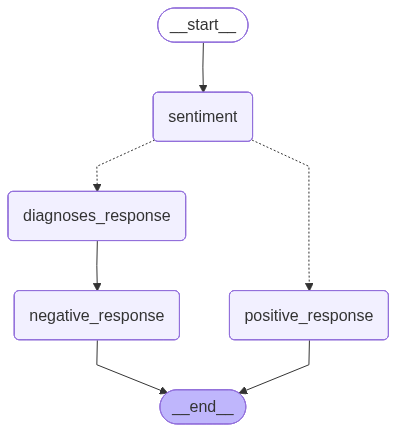

In [8]:
## define graph 
graph = StateGraph(sentiment_state)

## add graph node 
graph.add_node("sentiment",sentiment)
graph.add_node("positive_response",positive_response)
graph.add_node("negative_response",negative_response)
graph.add_node("diagnoses_response",diagnoses_response)

# add edges of graph 
graph.add_edge(START,"sentiment")
graph.add_conditional_edges("sentiment",conditional)
graph.add_edge("diagnoses_response","negative_response")
graph.add_edge("negative_response",END)
graph.add_edge("positive_response",END)

# compile the work flow
workflow = graph.compile()

workflow

In [9]:
text = " my gigabyte monitor is not working please check  " 

In [10]:
initiate_state={
    "text" : text
}
workflow.invoke(initiate_state)


{'text': ' my gigabyte monitor is not working please check  ',
 'sentiment': 'negative',
 'diagnoses': {'issue_type': 'defected',
  'urgency': 'high level',
  'tone': 'frustated'},
 'response': 'Here are a few positive response options, playing on the sentiment of frustration and the urgent, defected issue:\n\n**Option 1 (Direct & Reassuring):**\n\n> "Oh no, that\'s definitely frustrating when your Gigabyte monitor isn\'t working, especially with a high-level issue like that! Don\'t worry, we\'ll get to the bottom of this defect as quickly as possible. Please tell me more about what\'s happening!"\n\n**Option 2 (Empathetic & Action-Oriented):**\n\n> "I\'m so sorry to hear your Gigabyte monitor is out of commission – I can absolutely understand how frustrating that must be, especially when it\'s a critical issue. Let\'s tackle this defect together and get you back up and running. What exactly are you experiencing with the monitor?"\n\n**Option 3 (Slightly More Enthusiastic & Problem-Sol